In [1]:
import pandas as pd
import numpy as np
import random
import os

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [3]:
import matplotlib.pyplot as plt

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [5]:
# 'Industry_Status',
# 'Hispanic_Origin',
# 'Household_Status',
# 'Birth_Country',
# 'Birth_Country (Father)', 
# 'Birth_Country (Mother)'

In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [7]:
train.columns

Index(['ID', 'Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

### modify education

<BarContainer object of 17 artists>

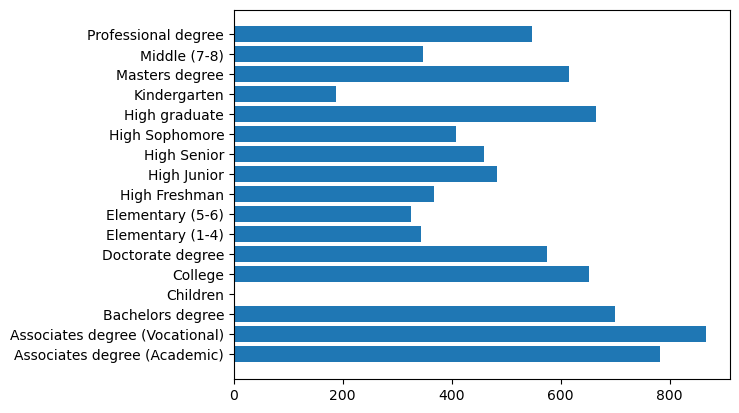

In [8]:
g = train.groupby('Education_Status', as_index=False)['Income'].mean()
plt.barh(g['Education_Status'], g['Income'],)

In [9]:
def modify_education(education):
    if education in ['Children', 'Kindergarten', 'Elementary (1-4)', 'Elementary (5-6)', 
                     'Middle (7-8)', 'High Freshman', 'High Sophomore', 
                     'High Junior', 'High Senior']:
        return 'dropout'
    elif education in ['College', 'Associates degree (Academic)', 'Associates degree (Vocational)']:
        return 'CommunityCollege'
    elif education in ['Professional degree', 'Masters degree']:
        return 'Masters degree'
    else:
        return education

In [10]:
train['Education'] = train['Education_Status']
train['Education'] = train['Education'].apply(modify_education)

In [11]:
test['Education'] = test['Education_Status']
test['Education'] = test['Education'].apply(modify_education)

<BarContainer object of 6 artists>

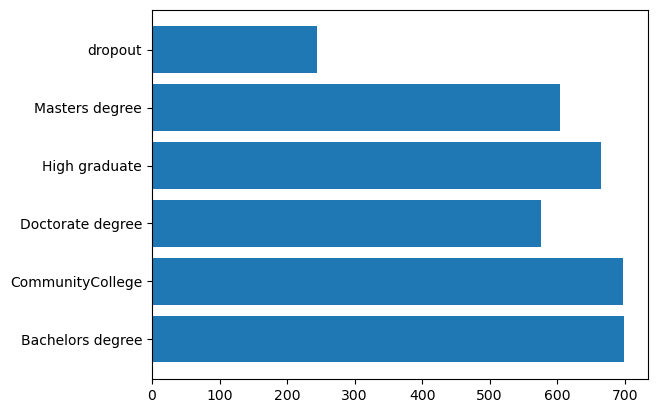

In [12]:
g = train.groupby('Education', as_index=False)['Income'].mean()
plt.barh(g['Education'], g['Income'],)

### modify marital status

<BarContainer object of 7 artists>

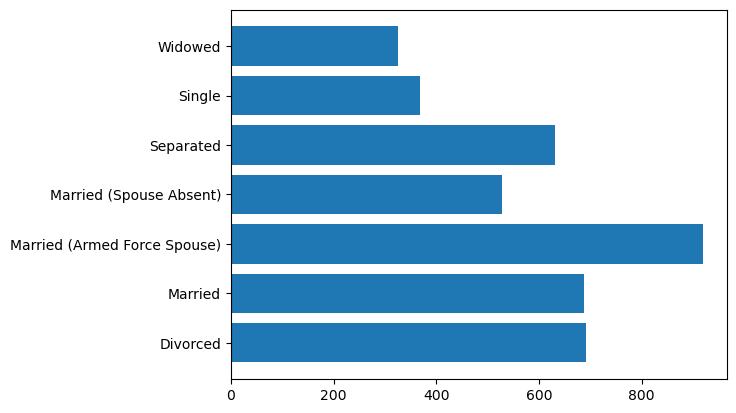

In [13]:
g = train.groupby('Martial_Status', as_index=False)['Income'].mean()
plt.barh(g['Martial_Status'], g['Income'],)

In [14]:
np.unique(train['Martial_Status'])

array(['Divorced', 'Married', 'Married (Armed Force Spouse)',
       'Married (Spouse Absent)', 'Separated', 'Single', 'Widowed'],
      dtype=object)

In [15]:
def modify_marital(marital):
    if marital in ['Married', 'Married (Armed Force Spouse)']:
        return 'Married'
    elif marital in ['Married (Spouse Absent)', 'Single']:
        return 'Single'
    elif marital in ['Separated', 'Divorced', 'Widowed']:
        return 'Separated'
    else:
        return marital

In [16]:
train['Martial_Status'] = train['Martial_Status'].apply(modify_marital)
test['Martial_Status'] = test['Martial_Status'].apply(modify_marital)

<BarContainer object of 3 artists>

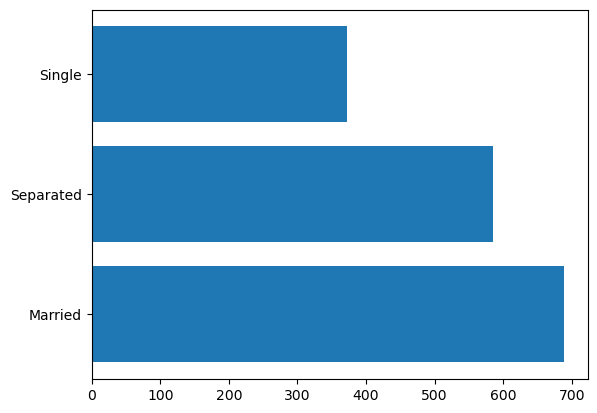

In [17]:
g = train.groupby('Martial_Status', as_index=False)['Income'].mean()
plt.barh(g['Martial_Status'], g['Income'])

In [18]:
trainval_x = train.drop(columns=['ID', 'Income', 
                                #  'Industry_Status',
                                 'Hispanic_Origin', 
                                 'Household_Status', 
                                 'Birth_Country', 
                                 'Birth_Country (Father)', 'Birth_Country (Mother)',
                                 'Education_Status'
                                 ])
trainval_y = train['Income']

test_x = test.drop(columns=['ID',
                            # 'Industry_Status',
                            'Hispanic_Origin', 
                            'Household_Status', 
                            'Birth_Country', 
                            'Birth_Country (Father)', 'Birth_Country (Mother)',
                            'Education_Status'
                            ])

In [19]:
encoding_target = list(trainval_x.dtypes[trainval_x.dtypes == "object"].index)

for i in encoding_target:
    le = LabelEncoder()
    
    # train과 test 데이터셋에서 해당 열의 모든 값을 문자열로 변환
    trainval_x[i] = trainval_x[i].astype(str)
    test_x[i] = test_x[i].astype(str)
    
    le.fit(trainval_x[i])
    trainval_x[i] = le.transform(trainval_x[i])
    
    # test 데이터의 새로운 카테고리에 대해 le.classes_ 배열에 추가
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case)
    
    test_x[i] = le.transform(test_x[i])

In [20]:
kf = KFold(n_splits=5)

In [21]:
num_fold = 1
total_train_error, total_val_error = 0, 0
test_preds = []
for train_idx, val_idx in kf.split(np.arange(len(trainval_x))):
    train_x = trainval_x.iloc[train_idx]
    train_y = trainval_y.iloc[train_idx]

    val_x = trainval_x.iloc[val_idx]
    val_y = trainval_y.iloc[val_idx]

    model = GradientBoostingRegressor(max_depth=7)
    model.fit(train_x, train_y)

    print(f'{num_fold} fold')

    train_y_hat = model.predict(train_x)
    val_y_hat = model.predict(val_x)

    pred = model.predict(test_x)
    test_preds.append(pred)

    train_error = mean_squared_error(train_y, train_y_hat) ** 0.5
    val_error = mean_squared_error(val_y, val_y_hat) ** 0.5

    total_train_error += train_error
    total_val_error += val_error

    print(f'train error : {train_error:.2f}')
    print(f'val error : {val_error:.2f}')
    
    print('-'*30)
    num_fold += 1

1 fold
train error : 446.97
val error : 658.32
------------------------------
2 fold
train error : 454.69
val error : 626.74
------------------------------
3 fold
train error : 467.22
val error : 614.80
------------------------------
4 fold
train error : 461.70
val error : 568.53
------------------------------
5 fold
train error : 468.94
val error : 581.17
------------------------------


In [22]:
print(f'final train error : {total_train_error/5:.2f}')
print(f'final val error : {total_val_error/5:.2f}')

final train error : 459.90
final val error : 609.91


### modify education
##### final train error : 456.20
##### final val error : 610.15

### modify marital status 1
##### final train error : 459.70
##### final val error : 610.35

### modify marital status 2
##### final train error : 459.90
##### final val error : 609.91

In [23]:
final_pred = np.array(test_preds).mean(0)

In [24]:
submission = pd.read_csv('data/sample_submission.csv')
submission

,ID,Income
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
9995,TEST_9995,0
9996,TEST_9996,0
9997,TEST_9997,0
9998,TEST_9998,0


In [25]:
submission['Income'] = final_pred
submission

,ID,Income
0,TEST_0000,-0.822151
1,TEST_0001,1.533063
2,TEST_0002,402.527110
3,TEST_0003,628.013290
4,TEST_0004,1.635511
...,...,...
9995,TEST_9995,921.073569
9996,TEST_9996,838.387039
9997,TEST_9997,373.057565
9998,TEST_9998,2.545503


In [26]:
os.makedirs('submission', exist_ok=True)
# submission.to_csv('submission/baseline_0314.csv', index=False)
submission.to_csv('submission/feat_engineering_0318_2.csv', index=False)